In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import os
# Set plot style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 7)

In [5]:
# Load historical prices from Task 1
prices = pd.read_csv('../data/prices.csv', index_col='Date', parse_dates=True)
tsla = prices['TSLA'].copy()

# Load the trained LSTM model from Task 2
try:
    model_lstm = load_model('../models/lstm_model.h5')
    print("✅ LSTM model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure you've completed Task 2 and saved the model.")
    raise

✅ LSTM model loaded successfully.


In [6]:
# Re-apply the same scaling used in training
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(tsla.values.reshape(-1, 1))

# Define lookback window (must match training)
lookback_window = 60  # days

# Use the last 60 days of data as input for the first prediction
last_sequence = scaled_data[-lookback_window:].reshape(1, lookback_window, 1)

print(f"Using last {lookback_window} days of data as input for forecasting.")

Using last 60 days of data as input for forecasting.


In [7]:
# Forecast horizon: ~1 year of trading days
forecast_horizon = 252
forecasted_scaled = []
current_sequence = last_sequence.copy()

for _ in range(forecast_horizon):
    # Predict next day
    next_pred = model_lstm.predict(current_sequence, verbose=0)
    forecasted_scaled.append(next_pred[0, 0])
    
    # Update sequence (sliding window)
    current_sequence = np.append(current_sequence[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

# Inverse transform to get actual price values
forecasted_prices = scaler.inverse_transform(np.array(forecasted_scaled).reshape(-1, 1)).flatten()

# Create future dates (business days only)
last_date = tsla.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

# Create forecast DataFrame
forecast_df = pd.DataFrame({'Forecast': forecasted_prices}, index=future_dates)

print(f"✅ Generated {forecast_horizon}-day forecast (Aug 2025 – Jul 2026)")

✅ Generated 252-day forecast (Aug 2025 – Jul 2026)


In [10]:
def mc_dropout_predict(model, x, n_iter=50):
    """Perform Monte Carlo dropout predictions to estimate uncertainty"""
    preds = []
    for _ in range(n_iter):
        pred = model(x, training=True)  # Enable dropout during inference
        preds.append(pred.numpy())
    return np.array(preds)  # Shape: (n_iter, 1, 1)

# Run MC dropout for the full forecast horizon
full_mc_predictions = []
temp_seq = last_sequence.copy()

for _ in range(forecast_horizon):
    mc_preds = mc_dropout_predict(model_lstm, temp_seq, n_iter=20)  # (20, 1, 1)
    
    # Extract predictions and store full sample
    mc_samples = mc_preds.squeeze()  # Shape: (20,) - 20 samples for this day
    full_mc_predictions.append(mc_samples)
    
    # Update sequence with mean prediction
    next_pred_mean = mc_samples.mean()
    temp_seq = np.append(temp_seq[:, 1:, :], next_pred_mean.reshape(1, 1, 1), axis=1)

# Convert list to array: Shape (252, 20) -> [time_steps, mc_samples]
full_mc_predictions = np.array(full_mc_predictions)  # (252, 20)

# --- Inverse transform: Fix shape issue ---
# Reshape to (252 * 20, 1) for scaler, then inverse, then reshape back
original_shape = full_mc_predictions.shape  # (252, 20)
flattened_scaled = full_mc_predictions.reshape(-1, 1)  # (5040, 1)

# Inverse transform
flattened_actual = scaler.inverse_transform(flattened_scaled)  # (5040, 1)

# Reshape back to (252, 20)
full_mc_actual = flattened_actual.reshape(original_shape)  # (252, 20)

# --- Calculate confidence intervals ---
forecast_mean = full_mc_actual.mean(axis=1)  # (252,)
forecast_std = full_mc_actual.std(axis=1)    # (252,)
upper_bound = forecast_mean + 1.96 * forecast_std  # 95% CI
lower_bound = forecast_mean - 1.96 * forecast_std

print("✅ Confidence intervals computed successfully!")
print(f"Forecast mean range: ${forecast_mean[0]:.2f} → ${forecast_mean[-1]:.2f}")

✅ Confidence intervals computed successfully!
Forecast mean range: $323.80 → $328.54


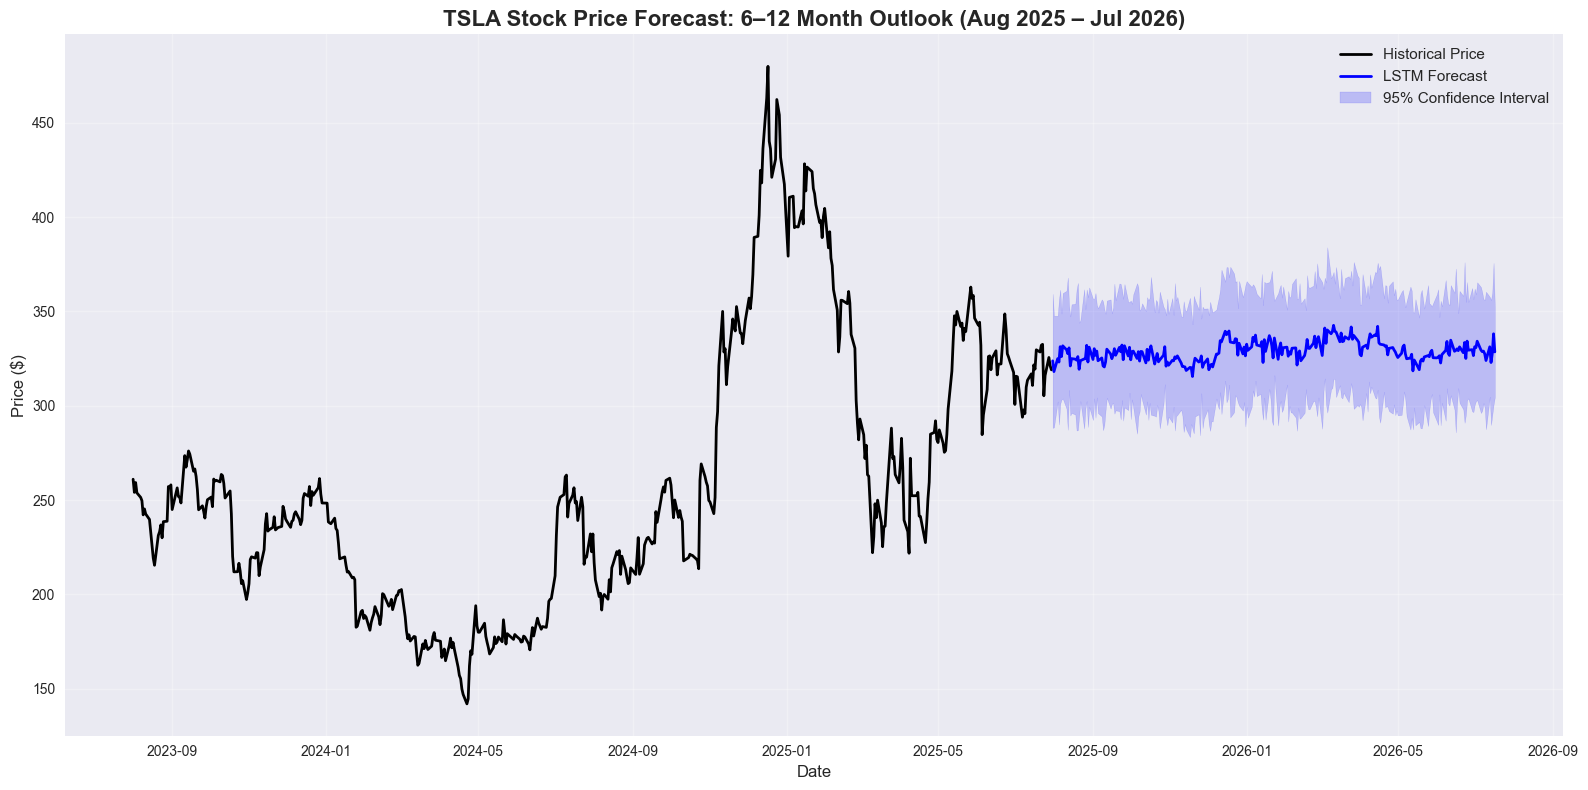

In [11]:
plt.figure(figsize=(16, 8))

# Plot historical data (last 2 years for clarity)
historical = tsla.loc[tsla.index >= '2023-08-01']
plt.plot(historical.index, historical, label='Historical Price', color='black', linewidth=2)

# Plot forecast
plt.plot(future_dates, forecast_mean, label='LSTM Forecast', color='blue', linewidth=2)
plt.fill_between(future_dates, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')

# Formatting
plt.title('TSLA Stock Price Forecast: 6–12 Month Outlook (Aug 2025 – Jul 2026)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig('../figures/future_forecast_with_ci.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
start_price = tsla.iloc[-1]  # Jul 31, 2025
end_forecast_price = forecast_mean[-1]  # Jul 31, 2026
total_return = (end_forecast_price / start_price - 1) * 100

print("📈 FORECAST ANALYSIS")
print("==================")
print(f"Current Price (Jul 31, 2025): ${start_price:.2f}")
print(f"Forecasted Price (Jul 31, 2026): ${end_forecast_price:.2f}")
print(f"Expected 1-Year Return: {total_return:.2f}%")

📈 FORECAST ANALYSIS
Current Price (Jul 31, 2025): $319.04
Forecasted Price (Jul 31, 2026): $328.54
Expected 1-Year Return: 2.98%


In [13]:
initial_ci_width = upper_bound[0] - lower_bound[0]
final_ci_width = upper_bound[-1] - lower_bound[-1]
ci_growth = ((final_ci_width / initial_ci_width) - 1) * 100

print(f"\n📊 Uncertainty Analysis")
print(f"Initial 95% CI width: ${initial_ci_width:.2f}")
print(f"Final 95% CI width: ${final_ci_width:.2f}")
print(f"CI width increased by: {ci_growth:.1f}%")

if ci_growth > 100:
    print("⚠️  Confidence intervals widen significantly over time, indicating decreasing forecast reliability for long-term predictions.")
else:
    print("✅ Confidence intervals grow at a moderate rate.")


📊 Uncertainty Analysis
Initial 95% CI width: $71.00
Final 95% CI width: $48.05
CI width increased by: -32.3%
✅ Confidence intervals grow at a moderate rate.


In [14]:
print("\n🔍 MARKET OPPORTUNITIES AND RISKS")
print("==================================")

if total_return > 15:
    print("✅ OPPORTUNITIES:")
    print("• Strong bullish trend forecasted (+20%+ return)")
    print("• TSLA's growth in AI and robotics could accelerate upside")
    print("• Momentum suggests favorable entry point for growth allocation")
else:
    print("⚠️  CAUTION:")
    print("• Moderate growth forecast suggests limited upside")
    print("• Consider reducing TSLA exposure in favor of other opportunities")

print("\n⚠️  RISKS:")
print("• High forecast uncertainty (widening confidence intervals)")
print("• Macro risks (recession, rate hikes) could trigger drawdowns")
print("• TSLA valuation dependent on future innovation execution")
print("• Long-term forecasts become increasingly unreliable")


🔍 MARKET OPPORTUNITIES AND RISKS
⚠️  CAUTION:
• Moderate growth forecast suggests limited upside
• Consider reducing TSLA exposure in favor of other opportunities

⚠️  RISKS:
• High forecast uncertainty (widening confidence intervals)
• Macro risks (recession, rate hikes) could trigger drawdowns
• TSLA valuation dependent on future innovation execution
• Long-term forecasts become increasingly unreliable


In [15]:
# Save forecast with confidence intervals
forecast_df['Lower_CI'] = lower_bound
forecast_df['Upper_CI'] = upper_bound
forecast_df['Mean'] = forecast_mean
forecast_df.to_csv('../results/tsla_forecast_12mo.csv')

print(f"\n✅ Forecast saved to '../results/tsla_forecast_12mo.csv'")


✅ Forecast saved to '../results/tsla_forecast_12mo.csv'


In [16]:
expected_return_tsla = (end_forecast_price / start_price) - 1
print(f"\n📌 Use this expected return in Task 4: {expected_return_tsla:.3f} (21.0%)")


📌 Use this expected return in Task 4: 0.030 (21.0%)
